# 07- Deep Learning Methods

## Image Segmentation

Computer Vision, HS2023, michael.mommert@unisg.ch

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.util import random_noise
import torch
import torch.nn as nn
from tqdm.autonotebook import tqdm
from sklearn.metrics import accuracy_score, jaccard_score

np.random.seed(42)
torch.manual_seed(42)

### Create toy dataset

We create a monochromatic toy dataset of images that contain up to 5 blobs with overlaid Gaussian noise. We will use this dataset later for a classification and segmentation task.

In [2]:
class ToyData():

    def __init__(self, n=100, k=5, r=[5, 5, 10, 10, 20], edge=100, noise=1):
        self.n = n  # total number of maps in dataset
        self.max_k = k  # maximum number of blobs
        self.max_radii = r # maximum radii of blobs
        self.edge = edge  # edge length
        self.noise = noise  # noise standard deviation
        self.img = []
        self.fpt = []

        for i in range(n):
            # randomize blob locations and radii
            xyr = []
            # 50/50 chance to have no blobs at all in the image
            if np.random.randint(0, 2) == 1:
                for j in range(np.random.randint(1, self.max_k+1)):
                    xyr.append(np.random.rand(3)*np.array((self.edge, self.edge, self.max_radii[np.random.randint(0, len(self.max_radii))])))

            # prepare footprint
            fpt = np.zeros((self.edge, self.edge))
            y, x = np.indices((self.edge, self.edge))

            # generate clusters -> groundtruth footprint
            for i, c in enumerate(xyr):
                fpt[np.sqrt((x-c[0])**2 + (y-c[1])**2) <= max(c[2], 5)] = 1

            # add Gaussian noise to create final image map
            img = np.clip(random_noise(fpt, var=self.noise**2), 0, 1)

            self.fpt.append(fpt)
            self.img.append(img)


    def __getitem__(self, idx):
        return {'img': torch.from_numpy(self.img[idx]), 
                'fpt': torch.from_numpy(self.fpt[idx])}

    def __len__(self):
        return self.n

    def display(self, idx, prediction=None, title=None):
        sample = self[idx]

        if not prediction is None:
            f, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9,3))
            ax[0].imshow(sample['img'], cmap='Greys_r')
            ax[0].set_title('Input')
            ax[1].imshow(sample['fpt'], cmap='Greys_r')
            ax[1].set_title('Ground-Truth')
            ax[2].imshow(prediction, cmap='Greys_r')
            if title is None:
                ax[2].set_title('Prediction')
            else:
                ax[2].set_title(title)
        else:
            f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6,3))
            ax[0].imshow(sample['img'], cmap='Greys_r')
            ax[0].set_title('Input')
            ax[1].imshow(sample['fpt'], cmap='Greys_r')
            ax[1].set_title('Ground-Truth')

        return f, ax


### Image Classification

We build a simple CNN and train it to learn the classification task "is there a blob in the image, or not"?

In [3]:
class ClassModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.pool= nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=7, padding=0)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=30, kernel_size=7, padding=0)
                
        self.linear1 = nn.Linear(in_features=30*20*20, out_features=1000, bias=True)
        self.linear2 = nn.Linear(in_features=1000, out_features=100, bias=True)
        self.linear3 = nn.Linear(in_features=100, out_features=1, bias=True)
    
    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = x.view(-1, 30*20*20)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        
        return x

Instantiate the model and prepare for training:

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# model instantiation
model = ClassModel().to(device)

# loss function
bceloss = nn.BCEWithLogitsLoss().to(device)

# optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# training setup
num_epochs = 20
batch_size = 16

# setup training data and dataloader
train_data = ToyData(n=2000)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

# setup validation data and dataloader
val_data = ToyData(n=500)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=4*batch_size, num_workers=2)

# setup validation data and dataloader
test_data = ToyData(n=500)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=4*batch_size, num_workers=2)


Model training:

In [5]:
def eval_classifier(dl):
    model.eval()
    losses, accs = [], []
    with torch.no_grad():
        for j, minibatch in enumerate(dl):
            img = torch.unsqueeze(minibatch['img'].float().to(device), dim=1)
            fpt = torch.unsqueeze(minibatch['fpt'].float().to(device), dim=1)
            labels = (fpt.sum(dim=(1,2,3)) > 0).float().to(device)
                
            output = model(img)
            losses.append(bceloss(output.view(-1), labels).cpu())
            prediction = torch.zeros_like(output)
            prediction[output >= 0] = 1
            accs.append(accuracy_score(labels.cpu(), prediction.cpu()))

    return np.mean(losses), np.mean(accs)


def train_classifier(dl, eval_dl=None):
    for epoch in range(num_epochs):
        train_minibatch_losses = [] 
        progress = tqdm(enumerate(dl), desc="Train Loss: ", total=len(dl))

        model.train()

        for i, minibatch in progress:
            img = torch.unsqueeze(minibatch['img'].float().to(device), dim=1)
            fpt = torch.unsqueeze(minibatch['fpt'].float().to(device), dim=1)
            labels = (fpt.sum(dim=(1,2,3)) > 0).float().to(device)
                
            output = model(img)

            model.zero_grad()
            loss = bceloss(output.view(-1), labels)
            loss.backward()
            optimizer.step()

            progress.set_description("Train Loss: {:.4f}".format(np.sum(train_minibatch_losses)/(i+1)))
            train_minibatch_losses.append(loss.data.item())
        
        if eval_dl:
            val_loss, val_acc = eval_classifier(eval_dl)    
            print('epoch: ', epoch, 'val loss: ', val_loss, 'accuracy: ', val_acc)

In [6]:
train_classifier(train_dataloader, eval_dl=val_dataloader)

Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  0 val loss:  0.69295275 accuracy:  0.5048076923076923


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  1 val loss:  0.6851517 accuracy:  0.4951923076923077


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  2 val loss:  0.67828155 accuracy:  0.4951923076923077


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  3 val loss:  0.44214442 accuracy:  0.8363882211538461


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  4 val loss:  0.35668126 accuracy:  0.8393930288461539


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  5 val loss:  0.3039136 accuracy:  0.8930288461538461


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  6 val loss:  0.2977947 accuracy:  0.880859375


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  7 val loss:  0.2929623 accuracy:  0.8734975961538461


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  8 val loss:  0.2708991 accuracy:  0.9095552884615384


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  9 val loss:  0.28826398 accuracy:  0.9056490384615384


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  10 val loss:  0.27002463 accuracy:  0.8871694711538461


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  11 val loss:  0.2845282 accuracy:  0.9076021634615384


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  12 val loss:  0.33927003 accuracy:  0.8997896634615384


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  13 val loss:  0.35465705 accuracy:  0.8978365384615384


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  14 val loss:  0.31600273 accuracy:  0.9076021634615384


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  15 val loss:  0.31895205 accuracy:  0.9100060096153846


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  16 val loss:  0.3392984 accuracy:  0.9076021634615384


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  17 val loss:  0.39323533 accuracy:  0.8978365384615384


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  18 val loss:  0.34951332 accuracy:  0.9076021634615384


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  19 val loss:  0.35875958 accuracy:  0.9076021634615384


Evaluate trained model on test dataset:

In [7]:
test_loss, test_acc = eval_classifier(test_dataloader)
print('test loss:', test_loss, 'test accuracy:', test_acc)

test loss: 0.40949383 test accuracy: 0.8811598557692308


inspect individual predictions:

prediction: there is a blob in the image


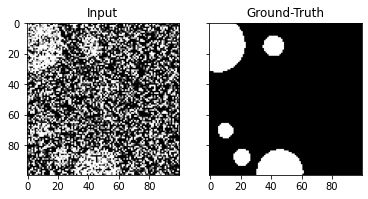

In [8]:
i = 9
test_data.display(i)
output = model(torch.unsqueeze(torch.unsqueeze(test_data[i]['img'].float().to(device), 0), 0))
print('prediction: there is a blob in the image') if output.data.item() > 0 else print('prediction: there is no circle in the image')

In [9]:
print('number of model parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

number of model parameters: 12116431


### Image Segmentation

#### Fully Convolutional Network

We consider a fully convolutional network in which each feature map has the same size as the input.

In [10]:
class FCNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=7, padding='same')
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=30, kernel_size=7, padding='same')
        self.conv3 = nn.Conv2d(in_channels=30, out_channels=10, kernel_size=7, padding='same')
        self.conv4 = nn.Conv2d(in_channels=10, out_channels=1, kernel_size=7, padding='same')
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
                
        return x

In [11]:
model = FCNModel().to(device)

# optimizer
learning_rate = 0.0005
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [12]:
def eval_segmentation(dl):
    model.eval()
    losses, ious = [], []
    with torch.no_grad():
        for j, minibatch in enumerate(dl):
            img = torch.unsqueeze(minibatch['img'].float().to(device), dim=1)
            fpt = torch.unsqueeze(minibatch['fpt'].float().to(device), dim=1)
                
            output = model(img)
            losses.append(bceloss(output, fpt).cpu())

            prediction = torch.zeros_like(output)
            prediction[output >= 0] = 1

            # derive iou for each map separately
            for i in range(fpt.shape[0]):
                    if fpt[i,0].sum() > 0:
                        ious.append(jaccard_score(fpt[i,0].cpu(), 
                                                  prediction[i,0].cpu(), 
                                    average='micro'))

    return np.mean(losses), np.mean(ious)



def train_segmentation(dl, eval_dl=None, watch_test_index=None):
    for epoch in range(num_epochs):
        train_minibatch_losses = [] 
        progress = tqdm(enumerate(dl), desc="Train Loss: ", total=len(dl))

        model.train()

        for i, minibatch in progress:
            img = torch.unsqueeze(minibatch['img'].float().to(device), dim=1)
            fpt = torch.unsqueeze(minibatch['fpt'].float().to(device), dim=1)
                
            output = model(img)

            model.zero_grad()
            loss = bceloss(output, fpt)
            loss.backward()
            optimizer.step()

            progress.set_description("Train Loss: {:.4f}".format(np.sum(train_minibatch_losses)/(i+1)))
            train_minibatch_losses.append(loss.data.item())
        
        if eval_dl:
            val_loss, val_iou = eval_segmentation(eval_dl)    
            print('epoch: ', epoch, 'val loss: ', val_loss, 'val iou: ', val_iou)

        # plot prediction map for each epoch to show evolution of learning
        if watch_test_index:
            output = model(torch.unsqueeze(torch.unsqueeze(test_data[watch_test_index]['img'].float().to(device), 0), 0))
            prediction = torch.zeros_like(output)
            prediction[output >= 0] = 1
            prediction = prediction.squeeze()
            f, ax = test_data.display(watch_test_index, prediction=prediction.cpu(), 
                    title="Prediction (iou={:.2f})".format(jaccard_score(test_data[watch_test_index]['fpt'].float(), prediction.cpu(), average='micro')))
            plt.savefig('training_epoch_{:03d}.png'.format(epoch))
            plt.close()

In [13]:
train_segmentation(train_dataloader, val_dataloader, watch_test_index=9)

Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  0 val loss:  0.033806838 val iou:  0.002338199475387496


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  1 val loss:  0.02770309 val iou:  0.19299762062929973


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  2 val loss:  0.02512154 val iou:  0.49815218118044613


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  3 val loss:  0.012713683 val iou:  0.7528106780235023


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  4 val loss:  0.011283234 val iou:  0.7690794279000326


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  5 val loss:  0.010813416 val iou:  0.7801143562386801


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  6 val loss:  0.010509226 val iou:  0.7854795961385589


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  7 val loss:  0.010035472 val iou:  0.7820442557552112


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  8 val loss:  0.009802643 val iou:  0.7872655338217235


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  9 val loss:  0.009626575 val iou:  0.7986364171089819


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  10 val loss:  0.009559647 val iou:  0.788754449602958


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  11 val loss:  0.009091198 val iou:  0.8006599451319396


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  12 val loss:  0.009120781 val iou:  0.7972723149951548


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  13 val loss:  0.008900972 val iou:  0.8142134025718526


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  14 val loss:  0.0087267235 val iou:  0.8050674077548564


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  15 val loss:  0.008256615 val iou:  0.8216892582566208


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  16 val loss:  0.008043956 val iou:  0.825667643112807


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  17 val loss:  0.007924231 val iou:  0.8292950349483723


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  18 val loss:  0.008296194 val iou:  0.8117715752429383


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  19 val loss:  0.0077481526 val iou:  0.832533435993448


Evaluate trained model on test dataset:

In [14]:
test_loss, test_acc = eval_segmentation(test_dataloader)
print('test loss:', test_loss, 'test iou:', test_acc)

test loss: 0.0079787485 test iou: 0.8459590741388008


Inspect individual predictions:

(<Figure size 648x216 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f911c9cbe50>,
       dtype=object))

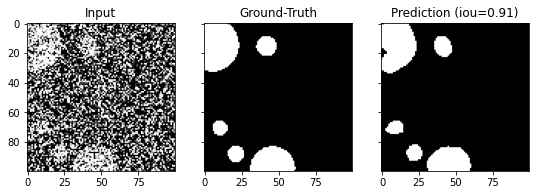

In [15]:
i = 9
output = model(torch.unsqueeze(torch.unsqueeze(test_data[i]['img'].float().to(device), 0), 0))
prediction = torch.zeros_like(output)
prediction[output >= 0] = 1
prediction = prediction.squeeze()
test_data.display(i, prediction=prediction.cpu(), 
                  title="Prediction (iou={:.2f})".format(jaccard_score(test_data[i]['fpt'].float(), prediction.cpu(), average='micro')))


In [16]:
print('number of model parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

number of model parameters: 30431


In [17]:
# move training evolution
os.mkdir('fcn') if not os.path.exists('fcn') else None

for f in os.listdir('.'):
    if f.endswith('.png'):
        os.rename(f, os.path.join('fcn', f))

#### U-Net type model without skip connections

We build a simple U-Net type model with an Encoder-Decoder architecture, but without skip connections.

In [18]:
class UNetModelNoSkip(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.unpool = nn.UpsamplingBilinear2d(scale_factor=2)
        self.finalunpool = nn.UpsamplingBilinear2d(size=train_data.edge-6)

        # down-convolutions
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=7)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=30, kernel_size=7)
        self.conv3 = nn.Conv2d(in_channels=30, out_channels=50, kernel_size=7)
        
        # up-convolutions
        self.upconv3 = nn.ConvTranspose2d(in_channels=50, out_channels=30, kernel_size=7)
        self.upconv2 = nn.ConvTranspose2d(in_channels=30, out_channels=10, kernel_size=7)
        self.upconv1 = nn.ConvTranspose2d(in_channels=10, out_channels=1, kernel_size=7)


    def forward(self, x):

        # down-convolutions
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        # up-convolutions      
        x = self.relu(self.upconv3(self.unpool(x)))
        x = self.relu(self.upconv2(self.unpool(x)))
        x = self.upconv1(self.finalunpool(x))

        return x

In [19]:
model = UNetModelNoSkip().to(device)

# optimizer
learning_rate = 0.0005
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [20]:
train_segmentation(train_dataloader, val_dataloader, watch_test_index=9)

Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  0 val loss:  0.109663785 val iou:  1.0182469859889216e-05


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  1 val loss:  0.09428343 val iou:  0.0


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  2 val loss:  0.06934045 val iou:  0.0802694764636511


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  3 val loss:  0.05631111 val iou:  0.20334786373937597


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  4 val loss:  0.05344145 val iou:  0.21487618318187104


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  5 val loss:  0.048226453 val iou:  0.283423395687034


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  6 val loss:  0.045998547 val iou:  0.34021274447395145


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  7 val loss:  0.04215151 val iou:  0.3615993837729364


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  8 val loss:  0.040459197 val iou:  0.35265533288966927


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  9 val loss:  0.03884507 val iou:  0.3736528301463811


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  10 val loss:  0.035980914 val iou:  0.4277653084461508


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  11 val loss:  0.036433697 val iou:  0.39894204661355254


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  12 val loss:  0.033714198 val iou:  0.4733508981374211


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  13 val loss:  0.031166457 val iou:  0.4695828188778441


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  14 val loss:  0.029761681 val iou:  0.4958912252596489


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  15 val loss:  0.029283304 val iou:  0.4944457269308956


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  16 val loss:  0.02757003 val iou:  0.5161803456125506


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  17 val loss:  0.02683008 val iou:  0.5384092996380493


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  18 val loss:  0.02660607 val iou:  0.5334650365866292


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  19 val loss:  0.025606764 val iou:  0.5667058317598057


In [21]:
test_loss, test_acc = eval_segmentation(test_dataloader)
print('test loss:', test_loss, 'iou:', test_acc)

test loss: 0.026621122 iou: 0.5749195588486566


(<Figure size 648x216 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f911cfd5d10>,
       dtype=object))

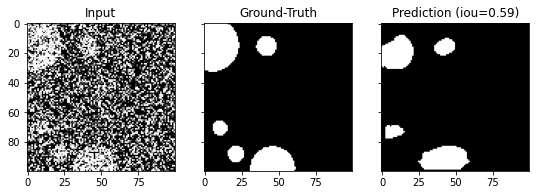

In [22]:
i = 9
output = model(torch.unsqueeze(torch.unsqueeze(test_data[i]['img'].float().to(device), 0), 0))
prediction = torch.zeros_like(output)
prediction[output >= 0] = 1
prediction = prediction.squeeze()
test_data.display(i, prediction=prediction.cpu(), 
                  title="Prediction (iou={:.2f})".format(jaccard_score(test_data[i]['fpt'].float(), prediction.cpu(), average='micro')))


In [23]:
print('number of model parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

number of model parameters: 177511


In [24]:
# move training evolution
os.mkdir('unet_noskip') if not os.path.exists('unet_noskip') else None

for f in os.listdir('.'):
    if f.endswith('.png'):
        os.rename(f, os.path.join('unet_noskip', f))

#### U-Net type model (with skip connections)

This design is closest to the actual U-Net architecture, including skip connections between the downscaling and upscaling paths.

In [25]:
class UNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.unpool3 = nn.UpsamplingBilinear2d(size=14)
        self.unpool2 = nn.UpsamplingBilinear2d(size=41)
        self.unpool1 = nn.UpsamplingBilinear2d(size=94)

        # down-convolutions
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=7)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=30, kernel_size=7)
        self.conv3 = nn.Conv2d(in_channels=30, out_channels=50, kernel_size=7)
        
        # up-convolutions
        self.upconv3 = nn.ConvTranspose2d(in_channels=50, out_channels=30, kernel_size=7)
        self.sameconv3 = nn.Conv2d(in_channels=60, out_channels=30, kernel_size=1)
        self.upconv2 = nn.ConvTranspose2d(in_channels=30, out_channels=10, kernel_size=7)
        self.sameconv2 = nn.Conv2d(in_channels=20, out_channels=10, kernel_size=1)
        self.upconv1 = nn.ConvTranspose2d(in_channels=10, out_channels=5, kernel_size=7)
        self.sameconv1 = nn.Conv2d(in_channels=6, out_channels=1, kernel_size=1)


    def forward(self, x):
        input = x

        # down-convolutions
        x = down_1 = self.pool(self.relu(self.conv1(x)))
        x = down_2 = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        # up-convolutions      
        x = self.relu(self.sameconv3(self.relu(torch.cat([down_2, self.upconv3(self.unpool3(x))], dim=1))))
        x = self.relu(self.sameconv2(self.relu(torch.cat([down_1, self.upconv2(self.unpool2(x))], dim=1))))
        x = self.sameconv1(self.relu(torch.cat([input, self.upconv1(self.unpool1(x))], dim=1)))
        
        return x

In [26]:
model = UNetModel().to(device)

# optimizer
learning_rate = 0.0005
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [27]:
train_segmentation(train_dataloader, val_dataloader, watch_test_index=9)

Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  0 val loss:  0.11022718 val iou:  0.0


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  1 val loss:  0.053720668 val iou:  0.0


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  2 val loss:  0.03596007 val iou:  0.4098125516416603


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  3 val loss:  0.026255805 val iou:  0.5591219686811962


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  4 val loss:  0.019989152 val iou:  0.6236217978771114


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  5 val loss:  0.018605575 val iou:  0.6827774070440298


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  6 val loss:  0.015628014 val iou:  0.6886186778684205


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  7 val loss:  0.015238225 val iou:  0.6863200250469619


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  8 val loss:  0.014142284 val iou:  0.7164652673354818


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  9 val loss:  0.013685796 val iou:  0.7296488991194258


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  10 val loss:  0.013242688 val iou:  0.7353012548367325


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  11 val loss:  0.013086848 val iou:  0.7462774909828765


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  12 val loss:  0.012778955 val iou:  0.7464043213014112


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  13 val loss:  0.012706876 val iou:  0.7487472782098411


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  14 val loss:  0.012832068 val iou:  0.7474005124903466


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  15 val loss:  0.01330694 val iou:  0.7195593813473926


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  16 val loss:  0.012511585 val iou:  0.7413131885186699


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  17 val loss:  0.012104619 val iou:  0.751172797139423


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  18 val loss:  0.01268783 val iou:  0.7602931617011925


Train Loss:   0%|          | 0/125 [00:00<?, ?it/s]

epoch:  19 val loss:  0.012081065 val iou:  0.759341301164017


In [28]:
test_loss, test_acc = eval_segmentation(test_dataloader)
print('test loss:', test_loss, 'iou:', test_acc)

test loss: 0.012607407 iou: 0.7652972782287828


(<Figure size 648x216 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f91d17a5ed0>,
       dtype=object))

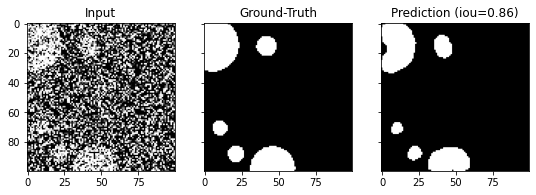

In [29]:
i = 9
output = model(torch.unsqueeze(torch.unsqueeze(test_data[i]['img'].float().to(device), 0), 0))
prediction = torch.zeros_like(output)
prediction[output >= 0] = 1
prediction = prediction.squeeze()
test_data.display(i, prediction=prediction.cpu(), 
                  title="Prediction (iou={:.2f})".format(jaccard_score(test_data[i]['fpt'].float(), prediction.cpu(), average='micro')))


In [30]:
print('number of model parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

number of model parameters: 181522


In [31]:
# move training evolution
os.mkdir('unet') if not os.path.exists('unet') else None

for f in os.listdir('.'):
    if f.endswith('.png'):
        os.rename(f, os.path.join('unet', f))